<a href="https://colab.research.google.com/github/xdr100/5241HW/blob/main/HW4Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Modules

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!dir

drive  sample_data


In [3]:
path='/content/drive/My Drive/5241Project/'

## Define Functions

In [4]:
def create_dataloader(x_path,y_path,batch_size=128,num_workers=0):
    '''
    Params:
    x_path: the path to the x file 
    y_path: the path to the y file
    '''
    #read the data from path
    x = pd.read_csv(x_path, sep = ' ',header = None)
    y = pd.read_csv(y_path, sep = ' ',header = None)
    #transform numpy array to tensor
    x_tensor = torch.Tensor(x.to_numpy().reshape(x.shape[0],x.shape[1])) #(n,784)
    y_tensor = torch.Tensor(y.to_numpy().reshape(y.shape[0],y.shape[1])) #(n,1)
    #float to int
    y_tensor = y_tensor.type(torch.LongTensor)
    #move the tensor to dataset and dataloader
    dataset = TensorDataset(x_tensor,y_tensor)
    dataloader = DataLoader(dataset,batch_size = batch_size,shuffle=True,num_workers = num_workers )
    return dataloader

## Dataframe to Torch Dataset
- !TODO explain why we need to use dataset  
- For the mini-batch gradient descent 

In [5]:
batch_size = 128
num_workers = 0 
#load the dataset
train_loader = create_dataloader(x_path=path+'train_x.txt',y_path=path+'train_y.txt',
                                 batch_size=batch_size,num_workers=num_workers)
valid_loader = create_dataloader(x_path=path+'test_x.txt',y_path=path+'test_y.txt',
                                 batch_size=batch_size,num_workers=num_workers)
# check if CUDA is available
use_cuda = torch.cuda.is_available()
#create a dictionary of dataset_loader
data_loaders = {'train':train_loader,'test':valid_loader}

In [ ]:
use_cuda

True

## Model Architecture

In [6]:
def init_model(model_input=784,hidden_out=100,model_out=10):
    fc_model = nn.Sequential(
        nn.Linear(model_input,hidden_out),
        nn.ReLU(),
        nn.Linear(hidden_out,model_out))
    return fc_model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, tol= 0.001, print_log = False,stop_train=False):
    '''
    Params:
        n_epoch: how many epochs of training
        loaders: the training & testing dataloads
        optimizer: optimizer used in the training process
        model: PyTorch model defined previously
        criterion: compute a gradient according to a given loss function
        use_cuda: if use cuda is true, train in GPU
        tol: the minimum different that keep the training 
        print_log: whether to print the training process or not
        stop_train: whether stop training when there's overfitting
    
    '''
    # initialize tracker for train/validation loss
    losses = {'train':[], 'validation':[]}
    accuracy = {'train':[],'validation':[]}
    valid_loss_min = np.Inf
    if use_cuda:
        model.cuda()
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0
        train_total = 0
        valid_correct = 0
        valid_total = 0
        
        ###################
        # train the model #
        ###################
        model.train() #dim of data (128,784) target(128,1,1)
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            #clean up the gradient   
            optimizer.zero_grad()
            #find the prediciton
            output = model(data) 
            #compute the loss
            loss = criterion(output,target.squeeze())
            #backpropagation
            loss.backward()
            #perform gradient update 
            optimizer.step() 
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss)) 
            # convert output probabilities to predicted class
            pred_label = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred_label.eq(target.data.view_as(pred_label))).cpu().numpy())
            train_total += data.size(0)
        #store the training loss
        losses['train'].append(train_loss)
        accuracy['train'].append(train_correct/train_total)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## compute the output from the model
            output = model(data)
            #compute loss
            loss = criterion(output,target.squeeze())
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # convert output probabilities to predicted class
            pred_label = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred_label.eq(target.data.view_as(pred_label))).cpu().numpy())
            valid_total += data.size(0)
        losses['validation'].append(valid_loss)
        accuracy['validation'].append(valid_correct/valid_total)
        #if the different between validation error is small, then stop the training process
        #print the parameter used in the training process 
        if stop_train:
            if valid_loss <= valid_loss_min:
                #model performance is not improving anymore
                #break the loop and print the current parameter used
                #print(f'Valid Loss Diff: {valid_loss_min - valid_loss}')
                if valid_loss_min - valid_loss <= tol:
                    break
                valid_loss_min = valid_loss
        # print training/validation statistics for every 10 epochs    
        if print_log:
            if epoch%10 ==0:
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, train_loss, valid_loss))
                print(f'Training Accuracy: {100.*train_correct/train_total:.2f} \t Validation Accuracy:{100.*valid_correct/valid_total:.2f}')
    print(f'Training used {epoch} epochs')
    return model, losses, accuracy

## Different model performances

Epoch: 10 	Training Loss: 0.262609 	Validation Loss: 0.226425
Training Accuracy: 92.54 	 Validation Accuracy:93.85
Epoch: 20 	Training Loss: 0.174762 	Validation Loss: 0.190316
Training Accuracy: 95.08 	 Validation Accuracy:94.40
Epoch: 30 	Training Loss: 0.123000 	Validation Loss: 0.175875
Training Accuracy: 96.61 	 Validation Accuracy:94.45
Epoch: 40 	Training Loss: 0.087580 	Validation Loss: 0.164614
Training Accuracy: 97.90 	 Validation Accuracy:94.65
Epoch: 50 	Training Loss: 0.063171 	Validation Loss: 0.162935
Training Accuracy: 98.61 	 Validation Accuracy:95.20
Epoch: 60 	Training Loss: 0.046787 	Validation Loss: 0.159156
Training Accuracy: 99.19 	 Validation Accuracy:95.25
Epoch: 70 	Training Loss: 0.035035 	Validation Loss: 0.155293
Training Accuracy: 99.51 	 Validation Accuracy:95.35
Epoch: 80 	Training Loss: 0.027087 	Validation Loss: 0.156889
Training Accuracy: 99.79 	 Validation Accuracy:95.55
Epoch: 90 	Training Loss: 0.021347 	Validation Loss: 0.161166
Training Accuracy:

Text(0, 0.5, 'loss')

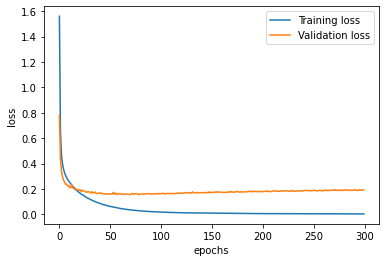

In [ ]:
epochs = 300
torch.manual_seed(0)
#initial the model
model = init_model()
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
#training process
retrained_model, losses, _ = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=True)
#321 indicate 3 rows 2 columns 
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')


As illustrated above, the training process starts converging and being overfitting after 150 epochs.

Epoch: 10 	Training Loss: 0.262731 	Validation Loss: 0.217578
Training Accuracy: 92.78 	 Validation Accuracy:93.70
Epoch: 20 	Training Loss: 0.172826 	Validation Loss: 0.186109
Training Accuracy: 95.01 	 Validation Accuracy:94.30
Epoch: 30 	Training Loss: 0.121486 	Validation Loss: 0.169206
Training Accuracy: 96.71 	 Validation Accuracy:94.80
Epoch: 40 	Training Loss: 0.087412 	Validation Loss: 0.167528
Training Accuracy: 97.91 	 Validation Accuracy:95.10
Epoch: 50 	Training Loss: 0.062937 	Validation Loss: 0.159720
Training Accuracy: 98.66 	 Validation Accuracy:95.70
Epoch: 60 	Training Loss: 0.045859 	Validation Loss: 0.160394
Training Accuracy: 99.19 	 Validation Accuracy:95.35
Epoch: 70 	Training Loss: 0.034668 	Validation Loss: 0.154685
Training Accuracy: 99.59 	 Validation Accuracy:95.75
Epoch: 80 	Training Loss: 0.026936 	Validation Loss: 0.158799
Training Accuracy: 99.78 	 Validation Accuracy:95.85
Epoch: 90 	Training Loss: 0.021074 	Validation Loss: 0.160622
Training Accuracy:

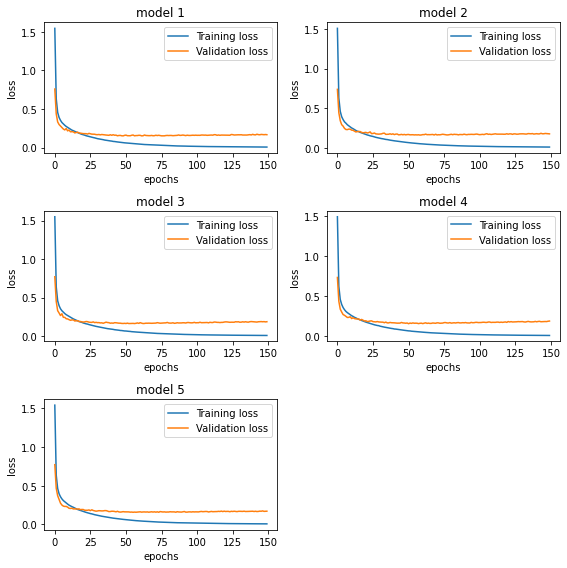

In [ ]:
epochs = 150
#generate fixed seed for different models
generated_seed = [random.randrange(0,2021) for _ in range(5)]
#learning rate 
lr = 0.1
#set the seed for training class
plt.figure(figsize=(8,8))
for idx, seed in enumerate(generated_seed):
    torch.manual_seed(seed)
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    #training process
    retrained_model, losses, _ = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=True)
    #321 indicate 3 rows 2 columns 
    plt.subplot(321+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(f'model {idx+1}')
plt.tight_layout()

The performanc is generally better in the training dataset than in the validation dataset, and after about 25 epochs, the performance is still increased on the training dataset, while the perfroamce is getting worse on the validation dataset.

## Part B

Training used 150 epochs


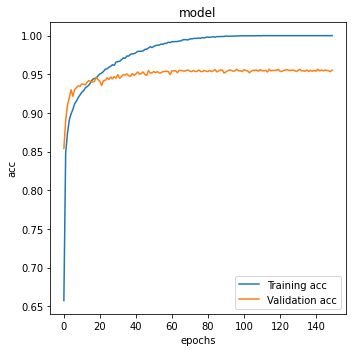

In [9]:
epochs = 150
#learning rate 
lr = 0.1
#set the seed for training class
plt.figure(figsize=(5,5))
torch.manual_seed(seed)
#initial the model
model = init_model()
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
#training process
retrained_model, losses, accuracy = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=False)
plt.plot(accuracy['train'], label='Training acc')
plt.plot(accuracy['validation'], label='Validation acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title(f'model')
plt.tight_layout()

The training accuracy keeps growing to 1.0, and the validation accuracy stop increasing after about 60 epochs. Compared with the plot of cross-entropy loss, it seems that the performance on the validation dataset is not getting worse with more training epochs and just keep stable instead. 

## Part C

In [10]:
import matplotlib.gridspec as gridspec

In [11]:
if use_cuda:
    retrained_model.cuda()

In [ ]:
classes = ["0","1","2","3","4","5","6","7","8","9"]
fig = plt.figure(figsize=(20, 30))
outer = gridspec.GridSpec(10, 5, wspace=0.2, hspace=0.5)
for i, (images,labels) in enumerate(train_loader):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                      subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    
    ax = plt.Subplot(fig, inner[0])
    ax.imshow(np.transpose(images[i].reshape(28,28)/2+0.5,(0,1) ))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(classes[labels[i]])
    fig.add_subplot(ax)
    ax = plt.Subplot(fig, inner[1])
    ax.barh(classes,retrained_model(images[i].cuda()).detach().cpu().numpy())
    fig.add_subplot(ax)
    #fig.tight_layout()
    if i>=49:
      break
#fig.tight_layout()

Here we take one image as example to see its corresponding plot at each one of the 100 neurons at the hidden layer.

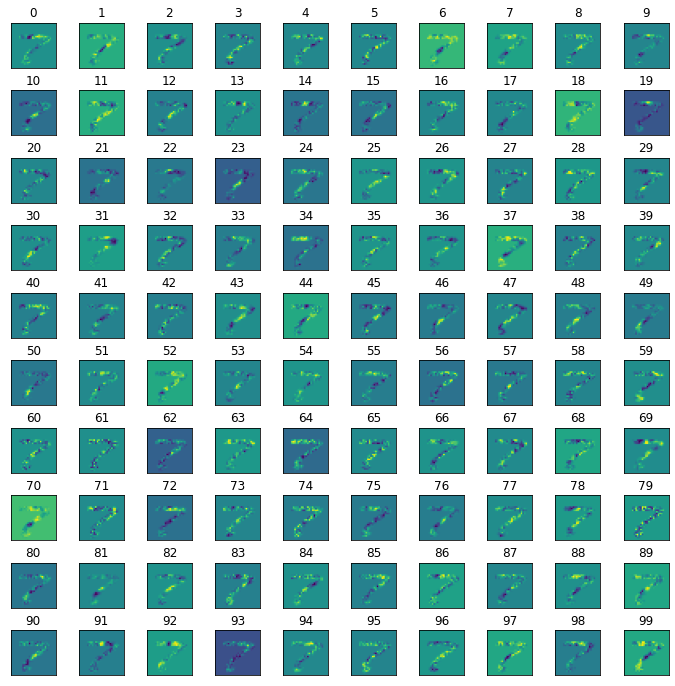

In [14]:
#to load a single image
for j, (img,labels) in enumerate(train_loader):
    if j==1:
      break

weight=retrained_model[0].weight.data.clone()
#bias=retrained_model[0].bias.data.clone()

fig = plt.figure(figsize=(12,12))
outer = gridspec.GridSpec(10, 10, wspace=0.2, hspace=0.5)
for i in range(100):
    inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                      subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    
    ax = plt.Subplot(fig, inner[0])
    ttt=weight[i].cpu()*img[0]  #+bias[i].cpu()
    
    ax.imshow(ttt.reshape(28,28))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(i)
    fig.add_subplot(ax)

We can see that they keep the original shape of the number.

## Part D
 - Try different learning rate [0.1, 0.01, 0.2, 0.5]
 - Try different momentum [0.0,0.5,0.9]
 - Keep a track of how many epochs need to train so that no improvement

In [ ]:
#set the training epochs 
n_epochs = 150
for lr in [0.1,0.01,0.2,0.5]:
    for moment in [0,0.5,0.9]:
        print('\nInitial Parameters:\t')
        print(f'lr: {lr}\t momentum: {moment} \n')
        #initial the model
        model = init_model()
        #define the criterion
        criterion = nn.CrossEntropyLoss()
        #initial the optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
        #training process
        retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

        


Initial Parameters:	
lr: 0.1	 momentum: 0 

Training used 7 epochs

Initial Parameters:	
lr: 0.1	 momentum: 0.5 

Training used 7 epochs

Initial Parameters:	
lr: 0.1	 momentum: 0.9 

Training used 3 epochs

Initial Parameters:	
lr: 0.01	 momentum: 0 

Training used 25 epochs

Initial Parameters:	
lr: 0.01	 momentum: 0.5 

Training used 16 epochs

Initial Parameters:	
lr: 0.01	 momentum: 0.9 

Training used 8 epochs

Initial Parameters:	
lr: 0.2	 momentum: 0 

Training used 3 epochs

Initial Parameters:	
lr: 0.2	 momentum: 0.5 

Training used 5 epochs

Initial Parameters:	
lr: 0.2	 momentum: 0.9 

Training used 5 epochs

Initial Parameters:	
lr: 0.5	 momentum: 0 

Training used 7 epochs

Initial Parameters:	
lr: 0.5	 momentum: 0.5 

Training used 7 epochs

Initial Parameters:	
lr: 0.5	 momentum: 0.9 

Training used 150 epochs


Training used 7 epochs
Training used 8 epochs
Training used 5 epochs


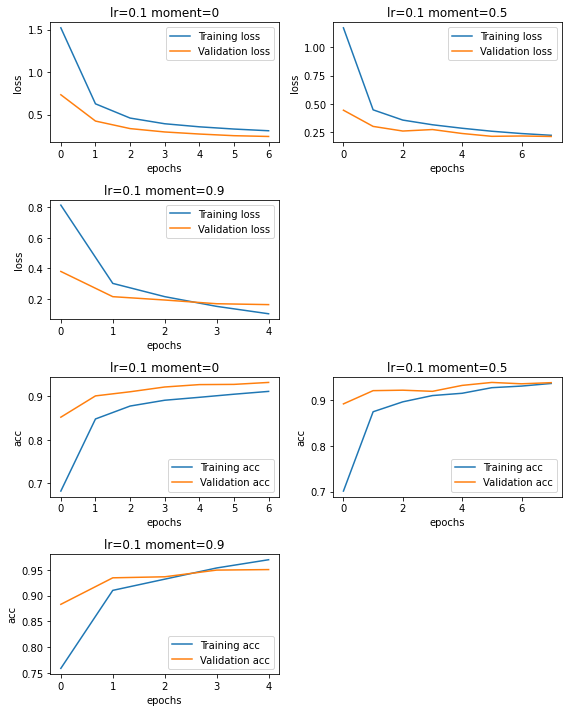

In [ ]:
#set the training epochs 
n_epochs = 150
lr =0.1 #0.01,0.2,0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Training used 24 epochs
Training used 17 epochs
Training used 10 epochs


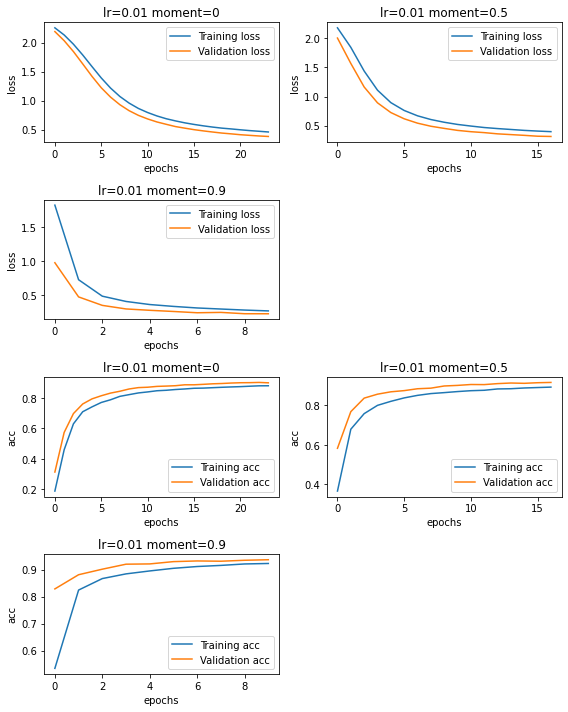

In [ ]:
#set the training epochs 
n_epochs = 150
lr =0.01 #,0.2,0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Training used 10 epochs
Training used 8 epochs
Training used 7 epochs


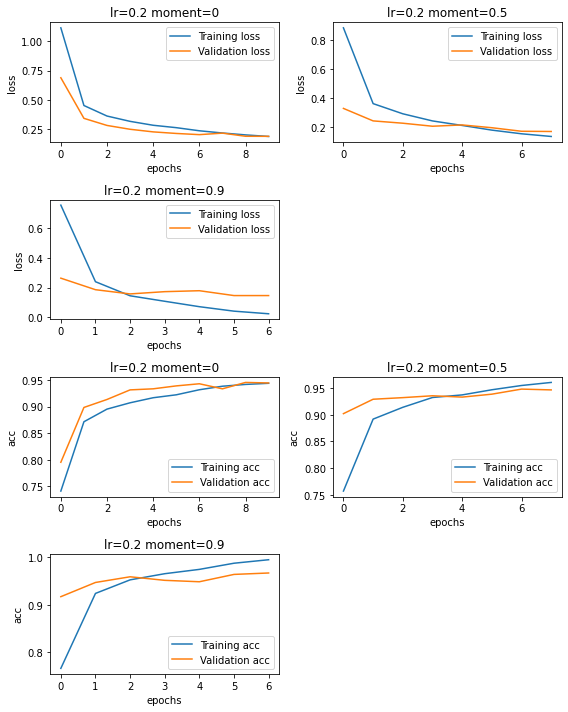

In [ ]:
#set the training epochs 
n_epochs = 150
lr =0.2#,0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Training used 8 epochs
Training used 3 epochs
Training used 150 epochs


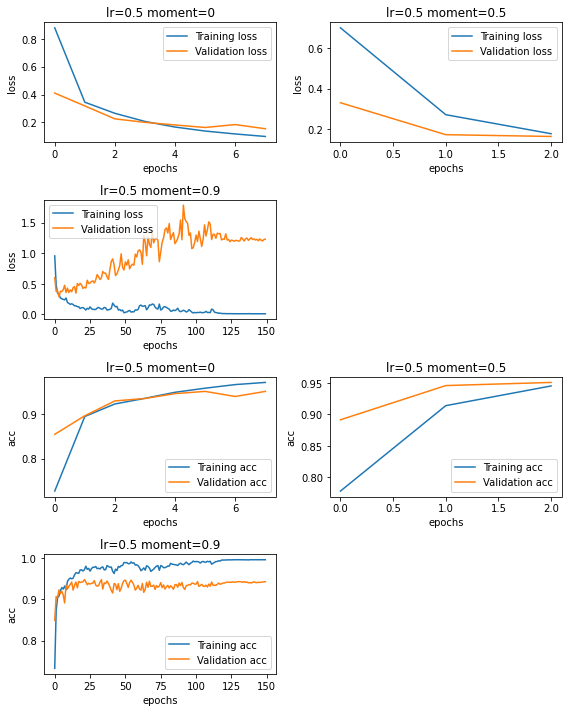

In [ ]:
#set the training epochs 
n_epochs = 150
lr =0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Epoch: 10 	Training Loss: 0.027396 	Validation Loss: 0.176731
Training Accuracy: 99.40 	 Validation Accuracy:95.00
Epoch: 20 	Training Loss: 0.004137 	Validation Loss: 0.154757
Training Accuracy: 100.00 	 Validation Accuracy:96.25
Epoch: 30 	Training Loss: 0.002185 	Validation Loss: 0.168347
Training Accuracy: 100.00 	 Validation Accuracy:96.15
Training used 30 epochs


Text(0.5, 1.0, 'lr=0.5 moment=0.9')

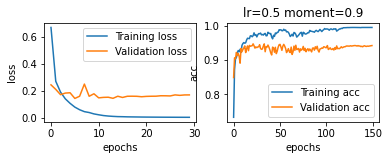

In [ ]:
epochs = 30
torch.manual_seed(seed)
#initial the model
model = init_model()
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.5,momentum=0.5)
#training process
retrained_model, losses, _ = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=True)
plt.subplot(221)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(222)
plt.plot(accuracy['train'], label='Training acc')
plt.plot(accuracy['validation'], label='Validation acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title("lr={} moment={}".format(lr,moment))

Result: 
   - if the lr(0.01) is small, using momentum can decrease the training epochs dramatically, and it appears that for small lr, large momentum is better than small momentum;
   - if the lr is too big, as the momentum is bigger it might not able to converge. (when lr=0.5, the momentum of 0.9 is much worse than the momentum of 0.5);
   - Basically, the choice of these parameters relies on the trial-and-error or cross-validation; The lr of 0.5 and the momentum of 0.5 results in the fastest convergence at the current stage;

## E (cnn)

In [ ]:
# define the CNN architecture
class Net(nn.Module):
    ### choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # Define layers of a CNN
        #input 1*28*28 -> 8*28*28 
        self.conv1_1 = nn.Conv2d(1,8,kernel_size= 3,stride=1,padding=1)
        # 8*28*28  -> 8*14*14
        self.maxpool1 = nn.MaxPool2d(2,2)
        #fully connected layer, padding
        self.fc1 = nn.Linear(8*14*14,100)
        #final layer output
        self.fc2 = nn.Linear(100,10)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.maxpool1(x)
        #flatten the shape 
        x = x.view(x.size(0),-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# instantiate the CNN
model_cnn = Net()


In [ ]:
def prepare_img_data(x_path,y_path,batch_size=128,num_workers=0):
    #read the data from path
    x = pd.read_csv(x_path, sep = ' ',header = None)
    y = pd.read_csv(y_path, sep = ' ',header = None)
    #transform numpy array to tensor
    x_tensor = torch.Tensor(x.to_numpy().reshape(x.shape[0],1,28,28))
    y_tensor = torch.Tensor(y.to_numpy().reshape(y.shape[0],y.shape[1]))
    #float to int
    y_tensor = y_tensor.type(torch.LongTensor)
    #move the tensor to dataset and dataloader
    dataset = TensorDataset(x_tensor,y_tensor)
    dataloader = DataLoader(dataset,batch_size = batch_size,shuffle=True,num_workers = num_workers)
    return dataloader

In [ ]:
train_dataloader = prepare_img_data(x_path = path+'train_x.txt', y_path=path+'train_y.txt')
test_dataloader = prepare_img_data(x_path = path+'test_x.txt', y_path=path+'test_y.txt')
#create a dictionary of dataset_loader
data_loaders = {'train':train_dataloader,'test':test_dataloader}

Epoch: 10 	Training Loss: 0.085935 	Validation Loss: 0.088004
Training Accuracy: 97.21 	 Validation Accuracy:97.60
Epoch: 20 	Training Loss: 0.044649 	Validation Loss: 0.095617
Training Accuracy: 98.54 	 Validation Accuracy:98.05
Epoch: 30 	Training Loss: 0.053373 	Validation Loss: 0.136354
Training Accuracy: 98.30 	 Validation Accuracy:97.40
Epoch: 40 	Training Loss: 0.020201 	Validation Loss: 0.187602
Training Accuracy: 99.44 	 Validation Accuracy:97.10
Epoch: 50 	Training Loss: 0.024991 	Validation Loss: 0.149561
Training Accuracy: 99.33 	 Validation Accuracy:97.85
Training used 50 epochs


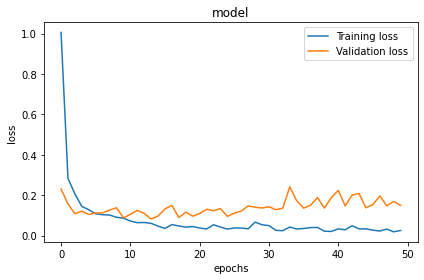

In [ ]:
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.2, momentum = 0.9)
#training process
retrained_model, losses, accuracy = train(50,data_loaders,model_cnn,optimizer,criterion,use_cuda,print_log=True,stop_train=True)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(f'model')
plt.tight_layout()

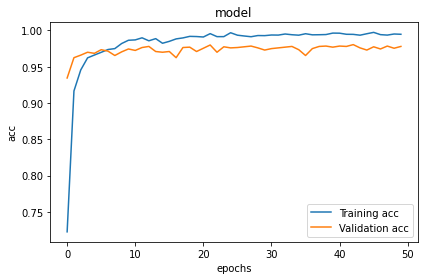

In [ ]:
plt.plot(accuracy['train'], label='Training acc')
plt.plot(accuracy['validation'], label='Validation acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title(f'model')
plt.tight_layout()

Compared with the single layer network, this CNN performs a bit worse on the training dataset, but performs better on the validation dataset, in terms of loss and accuracy;